In [4]:
import torch
import numpy as np
import os
import shutil
from datetime import datetime
import math
from math import exp
from random import seed
import random as rand
import matplotlib.pyplot as plt
import pickle 

import sys
sys.path.append('../common/')
from utils import *
from optimisation import *
from loo_cv import *
from one_dim import *

In [5]:
seed=0
torch.manual_seed(seed)

# Appendix: Testing candidate sets

In [8]:
colors = {'A':'blue','B':'red','C':'green'}

for b in [0.1,0.01,0.001]:
        plt.figure()
        for range_n, eps_v in zip(['A','B','C'],\
                [[0.001, 0.002, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75,1,2, 5, 7.5, 10, 20.0, 50, 75, 100, 200, 500, 1000],\
                         np.linspace(0.001,30,200),\
                         np.concatenate([np.linspace(0.001,30,200),[50.0, 75.0, 100.0, 200.0, 500.0, 1000.0]])\
                         ]):
            np.random.seed(42)
            a = 0 
            sample = 1
            n=10
            
            x_axis = sample_from_hypercube(sample,low=a, high=b, n=10)
            x_axis[:,0]=np.sort(x_axis[:,0])
            eps_init = initial_guess(x_axis)
            A =  get_int_matrix(x_axis,eps_init)
            f = lambda x: np.cos(2/b*np.pi*x)+x**2+x
            rhs = np.array([f(x) for x in x_axis])
            
            u_exact = f
            
            best_eps = 1.0
            old_error = np.inf
            
            for eps in eps_v:
                error = rippa_cv(eps, x_axis, rhs, stab=np.inf)
                if error < old_error:
                    best_eps = eps
                    old_error = error
            rippa_eps = best_eps
        
            
            error, b2 = compute_error(x_axis,a,b,rippa_eps,u_exact,vis=True)
            plt.plot(b2[2],b2[4],label=r'Rippa $\varepsilon=$'+f'{rippa_eps:.2f} Set: {range_n}',color=colors[range_n])
            
        plt.plot(b2[2],b2[3],label='true',color='black',ls='dotted',lw=2,alpha=0.25)
        plt.plot(b2[0],b2[1],ls='None',marker='o',label='pts',color='black')
        plt.legend(loc='best')
        plt.xlim([a,b])
        plt.savefig(f"NEW_range{b}_test_stability_rippa.pdf")
        plt.close()

In [10]:
colors = {'A':'blue','B':'red','C':'green'}

for b in [0.1,0.01,0.001]:
        plt.figure()
        for range_n, eps_v in zip(['A','B','C'],\
                        [[0.001, 0.002, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75,1,2, 5, 7.5, 10, 20.0, 50, 75, 100, 200, 500, 1000],\
                         np.linspace(0.001,30,200),\
                         np.concatenate([np.linspace(0.001,30,200),[50.0, 75.0, 100.0, 200.0, 500.0, 1000.0]])\
                         ]):
            np.random.seed(42)
            a = 0 
            sample = 1
            n=10
            
            x_axis = sample_from_hypercube(sample,low=a, high=b, n=10)
            x_axis[:,0]=np.sort(x_axis[:,0])
            eps_init = initial_guess(x_axis)
            A =  get_int_matrix(x_axis,eps_init)
            f = lambda x: np.cos(2/b*np.pi*x)+x**2+x
            rhs = np.array([f(x) for x in x_axis])
            u_exact = f

            best_eps = 1.0
            old_error = np.inf
            for eps in eps_v:
                error = mle_cv(eps, x_axis, rhs, stab=np.inf)
                if error < old_error:
                    best_eps = eps
                    old_error = error
            mle_eps = best_eps
            
            error, b7 = compute_error(x_axis,a,b,mle_eps,u_exact,vis=True)
            
            plt.plot(b7[2],b7[4],label=r'MLE $\varepsilon=$'+f'{mle_eps:.2f} Set: {range_n}',color=colors[range_n])
            
        plt.plot(b7[2],b7[3],label='true',color='black',ls='dotted',lw=2,alpha=0.25)
        plt.plot(b7[0],b7[1],ls='None',marker='o',label='pts',color='black')
        plt.legend(loc='best')
        plt.xlim([a,b])
        plt.savefig(f"NEW_range{b}_test_stability_MLE.pdf")
        plt.close()

/users/PAS2708/hanveiga1/RBF-shape-parameter-NN/1-dimensional/../common/loo_cv.py:50: RuntimeWarning: invalid value encountered in log
  term1 = np.log(np.dot(rhs2,w)+1e-16)
/users/PAS2708/hanveiga1/RBF-shape-parameter-NN/1-dimensional/../common/loo_cv.py:51: RuntimeWarning: invalid value encountered in log
  term2 = np.log(np.linalg.det(M)+1e-16)
/users/PAS2708/hanveiga1/RBF-shape-parameter-NN/1-dimensional/../common/loo_cv.py:50: RuntimeWarning: invalid value encountered in log
  term1 = np.log(np.dot(rhs2,w)+1e-16)
/users/PAS2708/hanveiga1/RBF-shape-parameter-NN/1-dimensional/../common/loo_cv.py:51: RuntimeWarning: invalid value encountered in log
  term2 = np.log(np.linalg.det(M)+1e-16)
/users/PAS2708/hanveiga1/RBF-shape-parameter-NN/1-dimensional/../common/loo_cv.py:50: RuntimeWarning: invalid value encountered in log
  term1 = np.log(np.dot(rhs2,w)+1e-16)


# Appendix: interpolation one dimension

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from datetime import datetime
import math
from math import exp
import time
from collections import defaultdict


def phi(f, x, y):
    z = (1 + (f * np.linalg.norm(x-y)) ** 2) ** (-0.5)
    return z

def add_midpoints(x, iterations):
    for itr in range(iterations):
        # Create a new list to store midpoints
        new_x = []
        
        # Iterate through the initial list and calculate midpoints
        for i in range(len(x) - 1):
            new_x.append(x[i])
            midpoint = (x[i] + x[i + 1]) / 2
            new_x.append(midpoint)
        
        # Add the last element of the original list
        new_x.append(x[-1])
        
        # Update the original list with the new list
        x = new_x
        
    return x
    
def one_interpolation(n,x_init,testcase,no_testcase,no_division,stab,ranges):
    # create the points based on how many times (no_division) we want to divide the x_init
    x_axis_total=add_midpoints(x_init, no_division)
        
    error=[0 for i in range(2)]
    
    A=np.zeros((n+1,n+1))     
    right_side=np.zeros((n+1,1))    
    w=np.zeros((n+1,1))
    origin=np.array([0,0])
    
    nn_time_accum = 0
    hardy_time_accum = 0
    franke_time_accum = 0
    mfranke_time_accum = 0
    rippa_time_accum = 0
    mle_time_accum=0

    keys = ['rippa','mle']
    epsilons = defaultdict(list, {key: [] for key in keys})

    #initialise the dictionary
    
    for y in range(2**no_division):
        x_axis1=np.array([x_axis_total[y*(n-1)+idx] for idx in range(n)])   
        x_axis_rippa=x_axis1.reshape(n,1)
        
        x_axis=np.zeros(2*x_axis1.shape[0])
        x_axis[::2] =x_axis1

        x_axis=x_axis.reshape(n,2)
        x_axis = sorted( x_axis, key = lambda x: np.linalg.norm(x - origin ) )#sort inputs
        x_axis = np.reshape(x_axis, (n,2)) 
    
        start = time.process_time()
        X=generate_distance_from_coordinates(x_axis)
        scaled_training_set_flat = upper_half(X).reshape((1,int(n*n/2-n/2)))
        scaled_training_set_tensor = torch.tensor(scaled_training_set_flat,dtype=torch.float)   
        shape_optimisation= model(scaled_training_set_tensor).item()
        
        start = time.process_time()
        rhs_rippa = np.array([testcase(x) for x in x_axis_rippa])
        
        eps_v = ranges 
        
        best_eps = 0
        old_error = np.inf
        for eps in eps_v:
            error_r = rippa_cv(eps, x_axis_rippa, rhs_rippa,stab=stab)
            if error_r < old_error:
               best_eps = eps
               old_error = error_r
        epsilons['rippa'].append(best_eps)
        rippa_time = (time.process_time() - start)
        rippa_time_accum+=rippa_time

        # MLE extension
        start = time.process_time()
        rhs_mle = np.array([testcase(x) for x in x_axis_rippa])
        
        best_mle_eps = 0
        old_error = np.inf
        
        for eps in eps_v:
            error_r = mle_cv(eps, x_axis_rippa, rhs_mle,stab=stab)
            if error_r < old_error:
               best_mle_eps = eps
               old_error = error_r
                
        epsilons['mle'].append(best_mle_eps)
        mle_time = (time.process_time() - start)
        mle_time_accum+=mle_time

        for count,key in enumerate(['rippa','mle']):
            try:
                shape = epsilons[key][-1]
                for i in range(n):
                    for j in range(n):            
                        A[i, j] = phi(shape, x_axis_total[i+y*(n-1)], x_axis_total[j+y*(n-1)])
                A[-1,:] =1.0
                A[:,-1] =1.0
                A[-1,-1]=0.0
            
                for i in range(n):
                    right_side[i,0]=testcase(x_axis_total[i+y*(n-1)])            
                right_side[-1,0]=0.0 
    
                # compute the weights
                w=np.linalg.solve(A, right_side) 
            
                x_axis_oversampled = np.zeros((n-1,1)) 
                for p in range(n-1):
                    x_axis_oversampled[p]=(x_axis_total[p+y*(n-1)]+x_axis_total[p+1+y*(n-1)])/2.0
    
                # compute the true values
                true_vals=np.zeros((n-1,1))
                for r in range(9):
                    true_vals[r,0]=testcase((x_axis_total[r+y*(n-1)]+x_axis_total[r+1+y*(n-1)])/2.0)
    
                # compute the approximate values
                s=np.zeros((n-1,n+1))
                for i in range(n):      
                    for j in range(n-1):            
                        s[j,i] = phi(shape, (x_axis_total[j+y*(n-1)]+x_axis_total[j+1+y*(n-1)])/2.0, x_axis_total[i+y*(n-1)])
                s[:,-1]=1.0        
                approximator_oversampled=np.matmul(s,w)
           
                for i in range(n-1):
                    error[count]=abs(approximator_oversampled[i,0]-true_vals[i,0])**2+error[count]
            except:
                for i in range(n-1):
                    error[count]=np.nan+error[count]

    part_error=[math.sqrt(err/len(x_axis_total))  for err in error]
    no_points=len(x_axis_total)
    timings = [rippa_time_accum, mle_time_accum]
            
    return no_points,part_error, timings, epsilons

In [19]:
from collections import defaultdict

from matplotlib.lines import Line2D

testcase1=lambda x: np.exp(np.sin(np.pi*x))
testcase2=lambda x: 1/(1+16*(x**2))
testcase3=lambda x: 1.0 if x>0.5 else 0.0

total_no_division=10
no_testcase=1
n=10

np.random.seed(42)

for testcase in [testcase1,testcase2,testcase3]:
    no_test= no_testcase
    
    for uniform in ['true','false']:
        fig=plt.figure()
        for range_n, ranges in zip(['A','B','C'],\
                            [[0.001, 0.002, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75,1,2, 5, 7.5, 10, 20.0, 50, 75, 100, 200, 500, 1000],\
                             np.linspace(0.001,30,200),\
                                     np.concatenate([np.linspace(0.001,30,200),[50.0, 75.0, 100.0, 200.0, 500.0, 1000.0]])\
                                     ]):
            x_vec=[]
            optimisation_error=[]
            hardy_error=[]
            franke_error=[]
            mfranke_error=[]
            rippa_error=[]
            mle_error = []
            
            if uniform=='true':
                x_init=[0,1/9,2/9,3/9,4/9,5/9,6/9,7/9,8/9,1]
            elif uniform =='false':
                x_init=[0.5+0.5*np.cos((2*k-1)*np.pi/20.0) for k in range(1,11)]
            x_init.sort()
    
            best_shapes_=defaultdict(list)
                
            for no_division in range(total_no_division):
                no_points,part_error,timings,best_shapes=one_interpolation(n,x_init,testcase,no_testcase,\
                                                                           no_division,16,ranges)
                x_vec.append(no_points)
                rippa_error.append(part_error[0])
                mle_error.append(part_error[1])
                best_shapes_['rippa'].append(np.mean(best_shapes['rippa']))
                best_shapes_['mle'].append(np.mean(best_shapes['mle']))
    
            print(f"{range_n} {mle_error}")
            print(f"{range_n} {rippa_error}")
            colors = {'NN': 'r', 'hardy': 'orange', 'franke':'g','mfranke':'purple','mle':'pink','rippa':'b'}
            labels = {'NN': 'NN', 'hardy': 'Hardy', 'franke':'Franke','mfranke':'Modified Franke','mle':'MLE','rippa':'Rippa'}
            
            plt.loglog(x_vec,rippa_error,marker='o',label=f"Rippa Range: {range_n}")
            plt.loglog(x_vec,mle_error,marker='o', label=f"MLE Range: {range_n}")
            
            plt.xlabel('N',fontsize=12)
            plt.ylabel('Error',fontsize=12)
            
            plt.legend(loc='best')
            
        plt.savefig(directory+'_testcase'+str(no_testcase)+uniform+range_n+'_grid_30.png')  
        
        plt.close()
    no_testcase+=1

/tmp/slurmtmp.663071/ipykernel_2165536/437009322.py:20: RuntimeWarning: invalid value encountered in log
  term2 = np.log(np.linalg.det(M)+1e-16)


A [0.0003962841957618864, 1.550300386086389e-05, 0.0002605890231872598, 1.6319536320816965e-05, 8.177064527705366e-06, 8.973621501963599e-05, 7.30359912190342e-06, 3.653917659859433e-06, 5.3579369134564774e-06, 2.6792949078658034e-06]
A [4.515716842131618e-06, 2.1396678201755634e-08, 4.536024136633258e-08, 1.2422943681559337e-06, 2.6396685917812033e-08, 2.506957914696231e-08, 7.509097342254723e-08, 3.487621995391356e-09, 1.871890469983785e-08, 4.978588483820755e-08]
B [0.0007686269372027394, 0.0007809577262809953, 0.0006489611051067153, 0.00034679457062166227, 7.087601839532346e-05, 5.967553202694886e-07, 8.528097058250893e-10, nan, nan, nan]
B [3.715096644579873e-06, 5.7670390378229134e-08, 1.4803562018570389e-08, 1.109700617221902e-06, 3.383006111358421e-08, 1.2163107426845552e-09, 5.974987128313055e-10, nan, nan, nan]
C [0.0007686269372027394, 0.0007809577262809953, 0.0006489611051067153, 0.00034679457062166227, 7.087601839532346e-05, 8.973621501963599e-05, 7.30359912190342e-06, 3.6

In [12]:
A_mle_1 = [0.0003962841957618864, 1.550300386086389e-05, 0.0002605890231872598, 1.6319536320816965e-05, 8.177064527705366e-06, 8.973621501963599e-05, 7.30359912190342e-06, 3.653917659859433e-06, 5.3579369134564774e-06, 2.6792949078658034e-06]
A_r_1 = [4.515716842131618e-06, 2.1396678201755634e-08, 4.536024136633258e-08, 1.2422943681559337e-06, 2.6396685917812033e-08, 2.506957914696231e-08, 7.509097342254723e-08, 3.487621995391356e-09, 1.871890469983785e-08, 4.978588483820755e-08]
B_mle_1 = [0.0007686269372027394, 0.0007809577262809953, 0.0006489611051067153, 0.00034679457062166227, 7.087601839532346e-05, 5.967553202694886e-07, 8.528097058250893e-10, np.nan, np.nan, np.nan]
B_r_1 = [3.715096644579873e-06, 5.7670390378229134e-08, 1.4803562018570389e-08, 1.109700617221902e-06, 3.383006111358421e-08, 1.2163107426845552e-09, 5.974987128313055e-10, np.nan, np.nan, np.nan]
C_mle_1 = [0.0007686269372027394, 0.0007809577262809953, 0.0006489611051067153, 0.00034679457062166227, 7.087601839532346e-05, 8.973621501963599e-05, 7.30359912190342e-06, 3.653917659859433e-06, 5.3579369134564774e-06, 2.6792949078658034e-06]
C_r_1=  [3.715096644579873e-06, 5.7670390378229134e-08, 1.4803562018570389e-08, 1.109700617221902e-06, 3.383006111358421e-08, 1.2163107426845552e-09, 5.974987128313055e-10, 3.487621995391356e-09, 1.871890469983785e-08, 4.978588483820755e-08]

A_mle_11 = [0.0002832303914702385, 0.00028148657284504273, 0.00041172614532525005, 0.0002587297368933477, 0.00011002520000649027, 4.6253350163115306e-05, 2.010142564789347e-05, 1.0265155522355825e-05, 6.18225129465486e-06, 3.1466167123330713e-06]
A_r_11= [7.694197187119233e-06, 3.5992910647216465e-07, 8.768914603218994e-06, 1.6302489987713814e-06, 7.573817200838162e-08, 4.4186699868012033e-07, 3.400523179185494e-07, 2.6931554922191864e-09, 7.131703352738824e-09, 5.9386629165188195e-09]
B_mle_11= [0.0007374211789513152, 0.0003593147873752305, 0.0015188337072605858, 0.0004570389079298914, 0.0001397943167289004, np.nan, np.nan, np.nan, np.nan, np.nan]
B_r_11= [6.698716945464753e-06, 6.073531413526983e-07, 2.20170595133441e-05, 5.432402956777089e-07, 8.813308071387308e-09, np.nan, np.nan, np.nan, np.nan, np.nan]
C_mle_11= [0.0007374211789513152, 0.0003593147873752305, 0.0015188337072605858, 0.0004570389079298914, 0.00017580078539686993, 4.6253350163115306e-05, 2.010142564789347e-05, 1.0265155522355825e-05, 6.18225129465486e-06, 3.1466167123330713e-06]
C_r_11= [6.698716945464753e-06, 6.073531413526983e-07, 2.20170595133441e-05, 5.432402956777089e-07, 8.813308071387308e-09, 9.064035958688573e-09, 6.761870544911345e-09, 2.6931554922191864e-09, 7.131703352738824e-09, 5.9386629165188195e-09]

A_mle_2= [0.0027815196549571606, 3.562198273646285e-05, 8.481857108169251e-05, 5.829211669037682e-06, 2.8518701839009577e-06, 3.079522490798061e-05, 2.5093246929094407e-06, 1.2551551174639515e-06, 1.840373516284448e-06, 9.203034465816833e-07]
A_r_2= [0.0027815196549571606, 0.00016891975315293153, 6.438445167622068e-05, 3.4081334916350956e-06, 1.3891300629774143e-08, 9.275037468183589e-09, 2.6034838226197815e-08, 1.206851136931263e-09, 6.433656369796369e-09, 1.7101837433043223e-08]
B_mle_2= [0.0032573327361504487, 0.0003285867511142767, 0.00019917660702458985, 0.00011744828089962163, 2.4318334722236212e-05, 2.0836073028256214e-07, 3.3905171941255545e-10, np.nan, np.nan, np.nan]
B_r_2= [0.0014767697569743096, 0.00014028938998946846, 5.355167695137162e-05, 2.401878618575759e-06, 8.418996284168299e-08, 2.046110898799948e-09, 2.3487226454242214e-10, np.nan, np.nan, np.nan]
C_mle_2= [0.0032573327361504487, 0.0003285867511142767, 0.00019917660702458985, 0.00011744828089962163, 2.4318334722236212e-05, 3.079522490798061e-05, 2.5093246929094407e-06, 1.2551551174639515e-06, 1.840373516284448e-06, 9.203034465816833e-07]
C_r_2= [0.0014767697569743096, 0.00014028938998946846, 5.355167695137162e-05, 2.401878618575759e-06, 8.418996284168299e-08, 2.046110898799948e-09, 2.3487226454242214e-10, 1.206851136931263e-09, 6.433656369796369e-09, 1.7101837433043223e-08]

A_mle_22= [0.0018422412116705896, 0.00083228622186478, 0.00015274349451197388, 9.860869580761772e-05, 3.6482918921109216e-05, 1.5692074613858174e-05, 6.571157656267826e-06, 3.3432775159838306e-06, 2.2321259428505342e-06, 1.1316981519993626e-06]
A_r_22= [0.0018422412116705896, 0.0004713359151368137, 0.00018329960932509355, 3.971459540367299e-06, 1.2279287015618243e-07, 1.7377585278798075e-07, 1.1345202001488299e-07, 7.022098487084738e-10, 1.6180998589136124e-09, 2.406359217671061e-09]
B_mle_22= [0.00229617924207431, 0.0008878890061016754, 0.0005747052723318491, 0.00016353723028767324, 4.558208506583587e-05, np.nan, np.nan, np.nan, np.nan, np.nan]
B_r_22= [0.0012381565983658252, 0.0003165558698186508, 3.173795860356944e-05, 6.3937776824223635e-06, 2.5837427433981834e-07, np.nan, np.nan, np.nan, np.nan, np.nan]
C_mle_22= [0.00229617924207431, 0.0008878890061016754, 0.0005747052723318491, 0.00016353723028767324, 5.769397319787633e-05, 1.5692074613858174e-05, 6.571157656267826e-06, 3.3432775159838306e-06, 2.2321259428505342e-06, 1.1316981519993626e-06]
C_r_22= [0.0012381565983658252, 0.0003165558698186508, 3.173795860356944e-05, 6.3937776824223635e-06, 2.5837427433981834e-07, 8.146814948751965e-09, 2.7565576401975817e-09, 7.022098487084738e-10, 1.6180998589136124e-09, 2.406359217671061e-09]

A_mle_3= [0.1860866274990441, 0.05519026619781623, 0.050960870337461425, 0.03057346957023315, 0.021693126846634082, 0.020116764416159512, 0.011921912396105119, 0.008433720016637544, 0.006573659429538134, 0.0046487833936271]
A_r_3= [0.16856331229485838, 0.08069654498469422, 0.05782702890818209, 0.041168999355124844, 0.03210585794813323, 0.02274151323621735, 0.016094606921252138, 0.012422447161241627, 0.008785901842293156, 0.0046487833936271]
B_mle_3= [0.18063918232757517, 0.07835924112101811, 0.056149488956154625, 0.03997376573778008, 0.025742676401396936, 0.013849880520759965, 0.008352790262303934, np.nan, np.nan, np.nan]
B_r_3=[0.16912339499241205, 0.08260002345211458, 0.05918864809855871, 0.042266539995542286, 0.025742676401396936, 0.013849880520759965, 0.008352790262303934, np.nan, np.nan, np.nan]
C_mle_3= [0.18063918232757517, 0.07835924112101811, 0.056149488956154625, 0.03997376573778008, 0.025742676401396936, 0.020116764416159512, 0.011921912396105119, 0.008433720016637544, 0.006573659429538134, 0.0046487833936271]
C_r_3= [0.16912339499241205, 0.08260002345211458, 0.05918864809855871, 0.042266539995542286, 0.03210585794813323, 0.02274151323621735, 0.016094606921252138, 0.012422447161241627, 0.008785901842293156, 0.0046487833936271]
A_mle_33= [0.16554151633254158, 0.08934200410847551, 0.048461979654191155, 0.03511152937551012, 0.02503358607028604, 0.019564689218826387, 0.013846307378173512, 0.009795062722619536, 0.005182663896320876, 0.003997988798744583]
A_r_33= [0.16554151633254158, 0.1180700483089358, 0.08170482270861434, 0.0581636290661585, 0.04126901056191364, 0.027635737837391323, 0.019558343934791327, 0.015359643126104062, 0.009816525956785995, 0.005397922430740709]
B_mle_33= [0.16512715729047137, 0.0903471201446457, 0.05744761409757423, 0.0404363189954012, 0.028491427265639187, np.nan, np.nan, np.nan, np.nan, np.nan]
B_r_33= [0.16512715729047137, 0.11543957139682398, 0.08562754480692508, 0.05451420067923131, 0.029904995586201046, np.nan, np.nan, np.nan, np.nan, np.nan]
C_mle_33= [0.16512715729047137, 0.0903471201446457, 0.05744761409757423, 0.0404363189954012, 0.028491427265639187, 0.019564689218826387, 0.013846307378173512, 0.009795062722619536, 0.005182663896320876, 0.003997988798744583]
C_r_33= [0.16512715729047137, 0.11543957139682398, 0.08170482270861434, 0.0581636290661585, 0.04126901056191364, 0.027635737837391323, 0.019558343934791327, 0.015359643126104062, 0.009816525956785995, 0.005397922430740709]

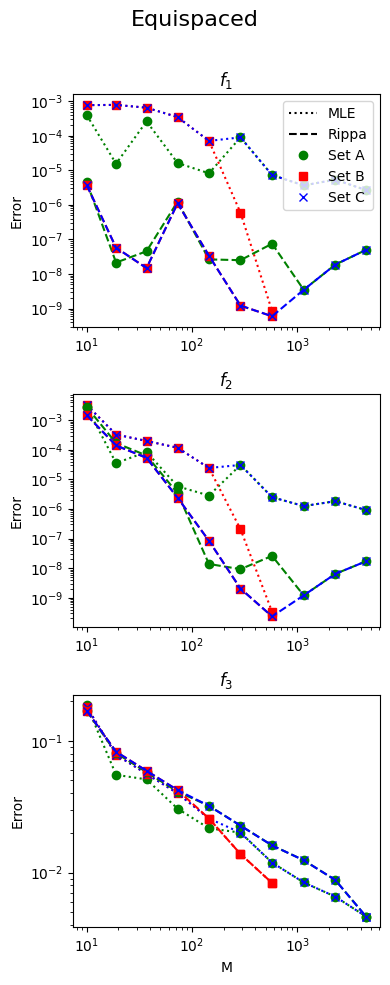

In [54]:
from matplotlib.lines import Line2D
fig, axs = plt.subplots(3, 1, figsize=(4, 10))
axs[0].set_title("$f_1$")
axs[0].loglog(x_vec,A_mle_1,marker='o',color='g',ls='dotted')
axs[0].loglog(x_vec,B_mle_1,marker='s',color='r',ls='dotted')
axs[0].loglog(x_vec,C_mle_1,marker='x',color='b',ls='dotted')

axs[0].loglog(x_vec,A_r_1,marker='o',color='g',ls='--')
axs[0].loglog(x_vec,B_r_1,marker='s',color='r',ls='--')
axs[0].loglog(x_vec,C_r_1,marker='x',color='b',ls='--')
axs[1].set_title("$f_2$")
axs[1].loglog(x_vec,A_mle_2,marker='o',color='g',ls='dotted')
axs[1].loglog(x_vec,B_mle_2,marker='s',color='r',ls='dotted')
axs[1].loglog(x_vec,C_mle_2,marker='x',color='b',ls='dotted')

axs[1].loglog(x_vec,A_r_2,marker='o',color='g',ls='--')
axs[1].loglog(x_vec,B_r_2,marker='s',color='r',ls='--')
axs[1].loglog(x_vec,C_r_2,marker='x',color='b',ls='--')
axs[2].set_title("$f_3$")
axs[2].loglog(x_vec,A_mle_3,marker='o',color='g',ls='dotted')
axs[2].loglog(x_vec,B_mle_3,marker='s',color='r',ls='dotted')
axs[2].loglog(x_vec,C_mle_3,marker='x',color='b',ls='dotted')

axs[2].loglog(x_vec,A_r_3,marker='o',color='g',ls='--')
axs[2].loglog(x_vec,B_r_3,marker='s',color='r',ls='--')
axs[2].loglog(x_vec,C_r_3,marker='x',color='b',ls='--')

for i in range(3):
    axs[i].set_ylabel('Error')

axs[2].set_xlabel('M')

legend_elements = [
    Line2D([0], [0], linestyle=':', color='black', label='MLE'),
    Line2D([0], [0], linestyle='--', color='black', label='Rippa'),
    Line2D([0], [0], marker='o', color='g', linestyle='None', label='Set A'),
    Line2D([0], [0], marker='s', color='r', linestyle='None', label='Set B'),
    Line2D([0], [0], marker='x', color='b', linestyle='None', label='Set C'),
]

# Add legend to plot
axs[0].legend(handles=legend_elements, loc='upper right')

plt.suptitle('Equispaced', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
plt.savefig("equispaced_candidate_sets.png")

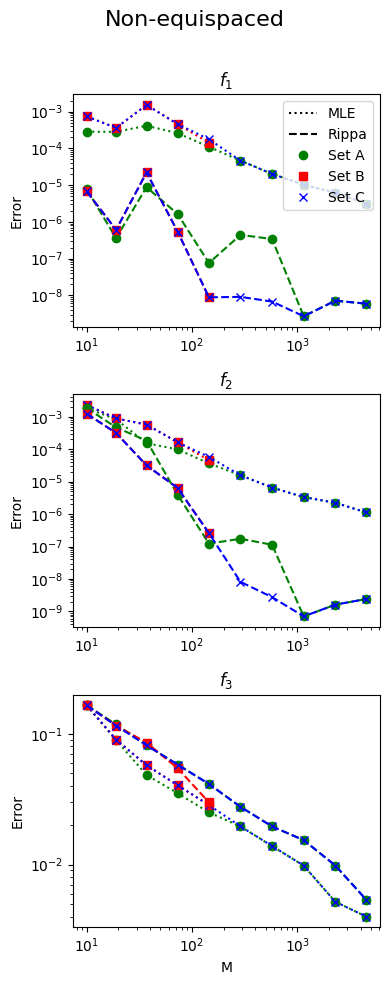

In [55]:
from matplotlib.lines import Line2D
fig, axs = plt.subplots(3, 1, figsize=(4, 10))
axs[0].set_title("$f_1$")
axs[0].loglog(x_vec,A_mle_11,marker='o',color='g',ls='dotted')
axs[0].loglog(x_vec,B_mle_11,marker='s',color='r',ls='dotted')
axs[0].loglog(x_vec,C_mle_11,marker='x',color='b',ls='dotted')

axs[0].loglog(x_vec,A_r_11,marker='o',color='g',ls='--')
axs[0].loglog(x_vec,B_r_11,marker='s',color='r',ls='--')
axs[0].loglog(x_vec,C_r_11,marker='x',color='b',ls='--')
axs[1].set_title("$f_2$")
axs[1].loglog(x_vec,A_mle_22,marker='o',color='g',ls='dotted')
axs[1].loglog(x_vec,B_mle_22,marker='s',color='r',ls='dotted')
axs[1].loglog(x_vec,C_mle_22,marker='x',color='b',ls='dotted')

axs[1].loglog(x_vec,A_r_22,marker='o',color='g',ls='--')
axs[1].loglog(x_vec,B_r_22,marker='s',color='r',ls='--')
axs[1].loglog(x_vec,C_r_22,marker='x',color='b',ls='--')
axs[2].set_title("$f_3$")
axs[2].loglog(x_vec,A_mle_33,marker='o',color='g',ls='dotted')
axs[2].loglog(x_vec,B_mle_33,marker='s',color='r',ls='dotted')
axs[2].loglog(x_vec,C_mle_33,marker='x',color='b',ls='dotted')

axs[2].loglog(x_vec,A_r_33,marker='o',color='g',ls='--')
axs[2].loglog(x_vec,B_r_33,marker='s',color='r',ls='--')
axs[2].loglog(x_vec,C_r_33,marker='x',color='b',ls='--')

for i in range(3):
    axs[i].set_ylabel('Error')

axs[2].set_xlabel('M')

legend_elements = [
    Line2D([0], [0], linestyle=':', color='black', label='MLE'),
    Line2D([0], [0], linestyle='--', color='black', label='Rippa'),
    Line2D([0], [0], marker='o', color='g', linestyle='None', label='Set A'),
    Line2D([0], [0], marker='s', color='r', linestyle='None', label='Set B'),
    Line2D([0], [0], marker='x', color='b', linestyle='None', label='Set C'),
]

# Add legend to plot
axs[0].legend(handles=legend_elements, loc='upper right')

plt.suptitle('Non-equispaced', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
plt.savefig("non_equispaced_candidate_sets.png")